Found 9867 images belonging to 4 classes.
Found 2465 images belonging to 4 classes.
Found 3076 images belonging to 4 classes.
Epoch 1/10
309/309 [==============================] - 2421s 8s/step - loss: 0.4942 - accuracy: 0.8031 - val_loss: 0.2085 - val_accuracy: 0.9197
Epoch 2/10
309/309 [==============================] - 2012s 7s/step - loss: 0.2459 - accuracy: 0.9028 - val_loss: 0.1547 - val_accuracy: 0.9343
Epoch 3/10
309/309 [==============================] - 2241s 7s/step - loss: 0.2227 - accuracy: 0.9102 - val_loss: 0.1378 - val_accuracy: 0.9379
Epoch 4/10
309/309 [==============================] - 2521s 8s/step - loss: 0.2035 - accuracy: 0.9174 - val_loss: 0.1352 - val_accuracy: 0.9387
Epoch 5/10
309/309 [==============================] - 2059s 7s/step - loss: 0.1939 - accuracy: 0.9236 - val_loss: 0.1256 - val_accuracy: 0.9436
Epoch 6/10
309/309 [==============================] - 2077s 7s/step - loss: 0.1783 - accuracy: 0.9257 - val_loss: 0.1295 - val_accuracy: 0.9416
Epoch 7/10

C:\Users\nksdk\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


97/97 [==============================] - 197s 2s/step


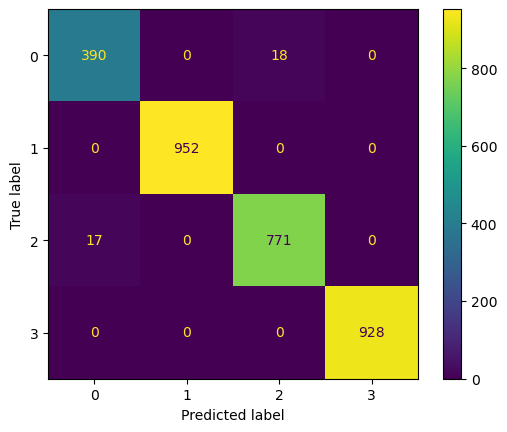

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       408
           1       1.00      1.00      1.00       952
           2       0.98      0.98      0.98       788
           3       1.00      1.00      1.00       928

    accuracy                           0.99      3076
   macro avg       0.98      0.98      0.98      3076
weighted avg       0.99      0.99      0.99      3076



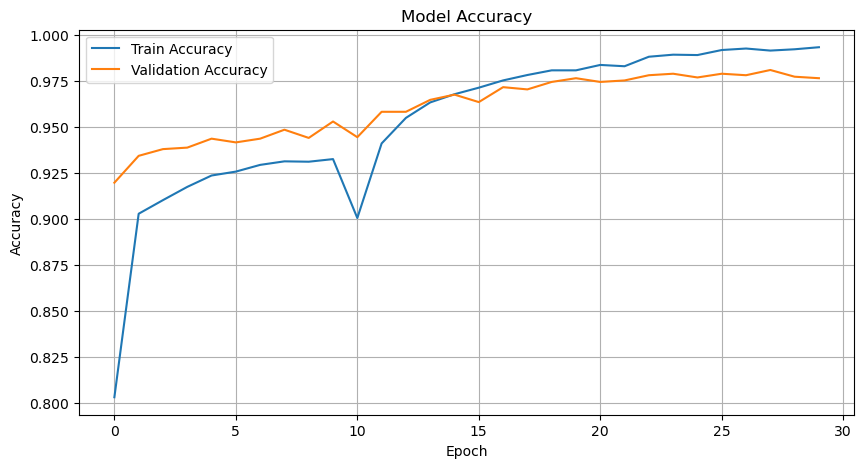

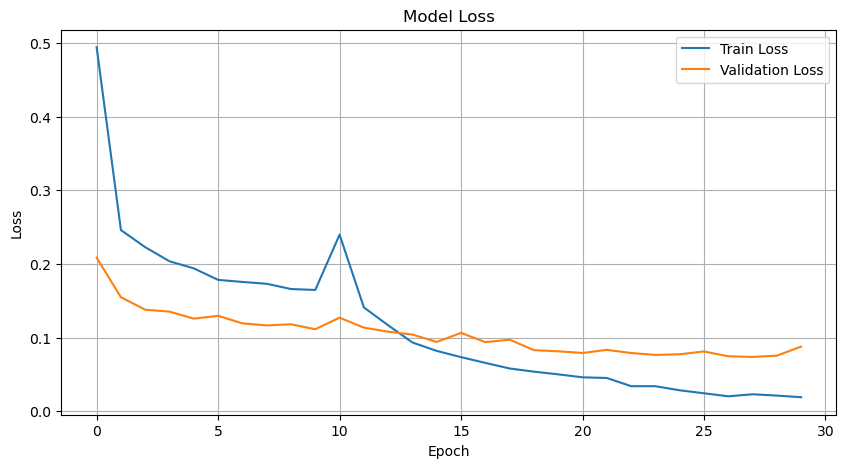

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import tensorflow as tf

# File paths
train_file_path = 'Train'
test_file_path = 'Test'

# Parameters
valid_split = 0.2
input_size = (224, 224)
input_shape = (224, 224, 3)
batch_size = 32
epochs = 30
initial_epochs = 10
fine_tune_epochs = epochs - initial_epochs
shuffle = True

# Data generators
train_gen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    horizontal_flip=True,
    validation_split=valid_split
)

test_gen = ImageDataGenerator(rescale=1/255.0)

train_data = train_gen.flow_from_directory(
    directory=train_file_path,
    target_size=input_size,
    color_mode='rgb',
    batch_size=batch_size,
    shuffle=shuffle,
    class_mode='categorical',
    subset='training'
)

valid_data = train_gen.flow_from_directory(
    directory=train_file_path,
    target_size=input_size,
    color_mode='rgb',
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical',
    subset='validation'
)

test_data = test_gen.flow_from_directory(
    directory=test_file_path,
    target_size=input_size,
    color_mode='rgb',
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

# Number of classes
num_classes = train_data.num_classes

# Inputs
inputs = Input(shape=input_shape)

# Feature extractors
effnet = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)
densenet = DenseNet121(include_top=False, weights='imagenet', input_tensor=inputs)

# Freeze base models initially
effnet.trainable = False
densenet.trainable = False

# Feature fusion
eff_out = effnet.output
dense_out = densenet.output

# Concatenate features
concat = Concatenate()([GlobalAveragePooling2D()(eff_out), GlobalAveragePooling2D()(dense_out)])
x = BatchNormalization()(concat)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Build model
model = Model(inputs=inputs, outputs=outputs)

# Compile and train
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Initial training
history = model.fit(train_data, validation_data=valid_data, epochs=initial_epochs)

# Unfreeze base models
effnet.trainable = True
densenet.trainable = True

# Recompile for fine-tuning
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training
history_finetune = model.fit(train_data, validation_data=valid_data, initial_epoch=initial_epochs, epochs=epochs)

# Save model
model.save("fusion_efficientnet_densenet.h5")

# Evaluate
model = tf.keras.models.load_model("fusion_efficientnet_densenet.h5")
preds = model.predict(test_data)
pred_labels = np.argmax(preds, axis=1)

# Confusion matrix and report
cm = confusion_matrix(test_data.classes, pred_labels)
ConfusionMatrixDisplay(cm).plot()
plt.show()
print(classification_report(test_data.classes, pred_labels))

# Accuracy Plot
acc = history.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
plt.figure(figsize=(10, 5))
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
loss = history.history['loss'] + history_finetune.history['loss']
val_loss = history.history['val_loss'] + history_finetune.history['val_loss']
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
